# Functional Variational Bayesian Neural Networks

Shengyang Sun, Guodong Zhang, Jiaxin Shi, Roger Grosse <[link](https://arxiv.org/pdf/1903.05779.pdf)>

In [1]:
import torch
import pandas as pd
import altair as alt
from vega_datasets import data
from datasets import DemoData

## Get the data

Build `train`, `test` and `f(x)` (full interval) `torch.Dataset` objects for
noisy functions `sin` (Bishop), `double_sin` (Gal) and `tricky_line` (Osband).
These objects have an additional `panda()` member that returns a `pd.DataFrame`.

In [2]:
trn_set, tst_set, fx_set = (DemoData('sin', mode) for mode in ['train', 'test', 'f(x)'])

In [3]:
data = pd.concat([dset.panda() for dset in [trn_set, tst_set, fx_set]])

You can visualize the true function (in green) and the test and train noisy points.

In [4]:
fx_plt = alt.Chart(data, width=640).mark_line(color='springgreen', strokeWidth=3).encode(
    x='x',
    y='y'
).transform_filter((alt.datum.series == 'f(x)'))

trn_tst_plt = alt.Chart(data).mark_circle(size=100).encode(
    x='x',
    y='y',
    color=alt.Color('series', scale=alt.Scale(domain=['train', 'test'],
                                              range=['slateblue', '#cd5a84'])),
    tooltip='y',
).transform_filter((alt.datum.series != 'f(x)'))

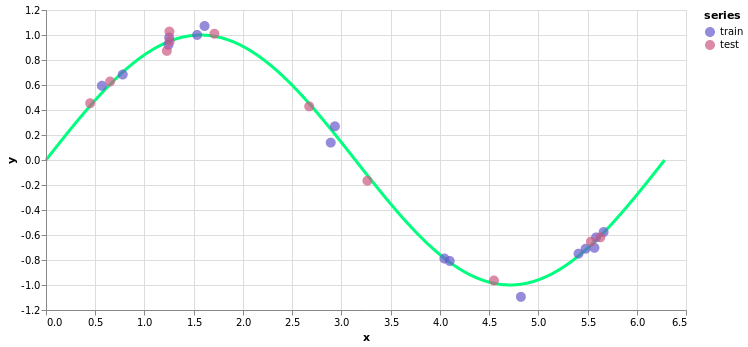

In [5]:
fx_plt + trn_tst_plt

In [6]:
def plot_test(μ, x_test, data):
    data = data.copy()
    data = data.append(
        pd.DataFrame(list(zip(x_test.squeeze().numpy(), μ.squeeze().numpy(), ['fit']*len(μ))), columns=data.columns),
        ignore_index=True
    )
    trn_fit_plt = alt.Chart(data).mark_circle(size=100).encode(
        x='x', y='y',
        color=alt.Color('series', scale=alt.Scale(domain=['train', 'test', 'fit'],
                                                  range=['slateblue','#cd5a84', 'orange'])),
        tooltip='y',
    ).transform_filter((alt.datum.series != 'f(x)'))
    return fx_plt + trn_fit_plt

## Gaussian Processes

Let us get back to the basic by fitting a Gaussian Process we will use as baseline for evaluating
the proposed fBNNs.

We first need to define a kernel we use to project our data in a feature space we can easily work with.

$$
k_{RBF}(\mathbf{x}_{i,:},\mathbf{x}_{j,:}) = \sigma^2 \exp \left( -\frac{1}{2\ell^2} \sum_{q=1}^Q (x_{i,q} - x_{j,q})^2\right)
$$

In [14]:
def euclidean_pairwise_dist(a, b=None):
    if b is not None:
        return (a - b.t())**2
    return (a - a.t())**2

def rbf_kernel(a, b=None, var=0.1, scale=1):
    dist = euclidean_pairwise_dist(a,b)
    return var * torch.exp(-(1/(2*scale**2)) * dist)

In [15]:
x_train = trn_set._DemoData__data.unsqueeze(0).t()
y_train = trn_set._DemoData__targets.unsqueeze(0).t()
x_test = tst_set._DemoData__data.unsqueeze(0).t()
x_full = fx_set._DemoData__data.unsqueeze(0).t()

In [16]:
def gp(x_train, x_test, y_train, ϵ=0.1):
    """Aici e procesu' gaussian."""
    kxx = rbf_kernel(x_train)
    kxt = rbf_kernel(x_train, x_test)
    ktt = rbf_kernel(x_test)
    print(kxx.shape, kxt.shape, ktt.shape)

    kxx_inv_kxt = torch.inverse(kxx + (torch.eye(len(kxx)) * ϵ)) @ kxt
    μ = kxx_inv_kxt.t() @ y_train
    Σ = ktt - (kxx_inv_kxt.t() @ kxt)
    return μ, Σ

In [17]:
μ_test, Σ_test = gp(x_train, x_test, y_train)

torch.Size([16, 16]) torch.Size([16, 11]) torch.Size([11, 11])


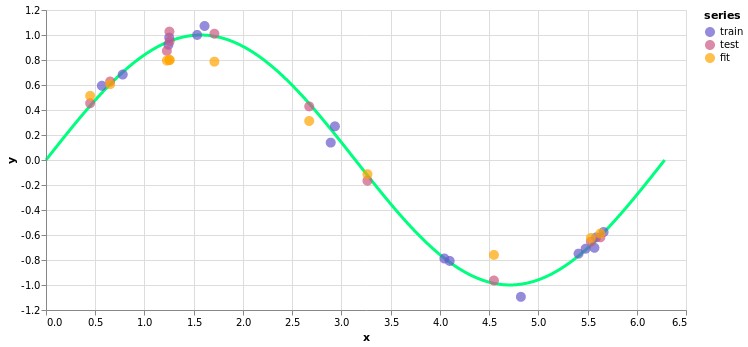

In [18]:
plot_test(μ_test, x_test, data)

So far this is more or less just linear regression. However we can fit a Multivariate Gaussian on the fited data.

## Let's now sample from the posterior

In [19]:
def sample_posterior(x_train, x_test, y_train, sample_no=5):
    
    μ, Σ = gp(x_train, x_test, y_train, ϵ=0.1)
    normal = torch.distributions.MultivariateNormal(μ.squeeze(), Σ + torch.eye(len(Σ))*0.00001)
    
    data = pd.DataFrame(list(zip(x_test.squeeze().numpy(), μ.squeeze().numpy(), ['fit']*len(μ))), columns=['x', 'y', 'series'])
    for i in range(sample_no):
        sample = normal.sample((1,))
        data = data.append(
            pd.DataFrame(list(zip(x_test.squeeze().numpy(), sample.squeeze().numpy(), [f's{i}']*len(μ))), columns=data.columns),
            ignore_index=True
        )
    μ_plt = alt.Chart(data, width=640).mark_line(color='navy', strokeWidth=3).encode(
        x='x',
        y='y'
    ).transform_filter((alt.datum.series == 'fit'))
    posterior_plt = alt.Chart(data).mark_line(strokeWidth=2, opacity=0.5).encode(
        x='x',
        y='y',
        color=alt.Color('series:O',
                    scale=alt.Scale(scheme='blues'),
                    legend=alt.Legend(title='p(θ)'))
    ).transform_filter((alt.datum.series != 'fit'))
    return (posterior_plt + μ_plt).resolve_scale(color='independent')

torch.Size([16, 16]) torch.Size([16, 50]) torch.Size([50, 50])


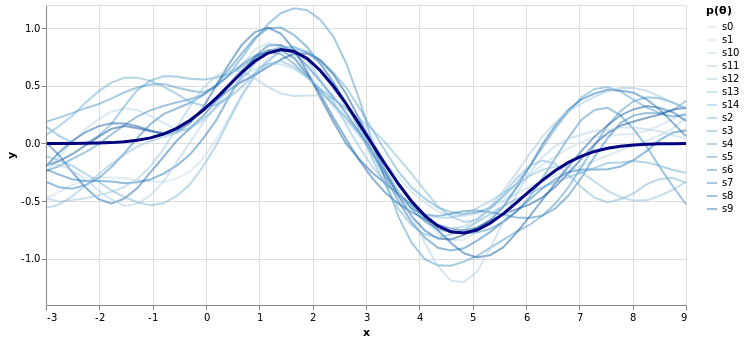

In [20]:
sample_posterior(x_train, torch.linspace(-3, 9, 50).unsqueeze(0).t(), y_train, sample_no=15)